In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mp
from matplotlib import cm
from collections import OrderedDict
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib import font_manager

import warnings
import time
warnings.filterwarnings('ignore')

Missing colon in file PosixPath('/Users/admin/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 1 ('sans-serif#### MATPLOTLIBRC FORMAT')
Missing colon in file '/Users/admin/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc', line 1 ('sans-serif#### MATPLOTLIBRC FORMAT')


# Functions

In [3]:
## Adjust graph spines
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 20))  # outward by 10 points
            #spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine
class test_result:
    def __init__(self, pay_head, poke_head,sale_head,bucket_head,poke_job,bucket_job):
        """
        :param labels:数组类型，真实的标签
        :param scores:数组类型，分类器的得分
        """
        self.pay_head = pay_head
        self.poke_head = poke_head
        self.sale_head = sale_head
        self.bucket_head = bucket_head
        self.poke_job = poke_job
        self.bucket_job = bucket_job
    

    def precision(self):
        """
        :return: 付费转化
        """
        try:
            precision = self.pay_head / self.poke_head
        except ZeroDivisionError:
            precision = np.nan
        
        return precision
 
    def recall(self):
        """
        :return: 收入召回
        """
        try:
            recall = self.sale_head / self.bucket_head
        except ZeroDivisionError:
            recall = np.nan
        
        return recall
    
    def block(self):
        try:
            block_range = self.poke_job / self.bucket_job
        except ZeroDivisionError:
            block_range = np.nan
        
        return block_range
    
    def f_beta(self,beta):
        precision = self.precision()
        recall = self.recall()
        
        f_score = (1+beta**2)*((precision*recall/((beta**2)*precision+recall)))
        return f_score
 
    def get_eval_metrics(self):
        print("Precision = {:0.3f},Recall = {:0.3f},Block Range = {:0.3f},F_score = {:0.3f}".format(self.precision(),self.recall(),self.block(),self.f_beta(beta = 0.5)))
    
    def get_eval_metrics_df(self,mon,stra):
        row = {"Strategy":[stra],"Month":[mon],"Precision":[self.precision()],"Recall":[self.recall()],"Block Range":[self.block()],"F_score":[self.f_beta(beta = 0.5)]}
        
        df = pd.DataFrame(row)
        return(df)
    
    def get_eval_metrics_df_2(self,mon,i,j,k):
        row = {"Month":[mon],"Precision":[self.precision()],"Recall":[self.recall()],"Block Range":[self.block()],"F_score":[self.f_beta(beta = 0.5)],"i":i,"j":j,"k":k}
        
        df = pd.DataFrame(row)
        return(df)
        
## calculate value    
def metric(dat,var):
    pay_head = dat.loc[(dat[var] == 1)&(dat.is_paid == 1),"h_boss_ratio_begin_bin"].count()
    poke_head = dat.loc[(dat.is_poked == "poked")&(dat[var] == 1),"h_boss_ratio_begin_bin"].count()

    sale_head = dat.loc[(dat[var] == 1),"sales"].sum()
    bucket_head = dat.loc[:,"sales"].sum()

    poke_job = dat.loc[(dat[var] == 1),"olj_1"].sum()
    bucket_job = dat.loc[:,"olj_1"].sum()

    test = test_result(pay_head,poke_head,sale_head,bucket_head,poke_job,bucket_job)

    test.get_eval_metrics()
 

# build dataframe
def metric_df(dat,var,mon,stra):
    pay_head = dat.loc[(dat[var] == 1)&(dat.is_paid == 1),var].count()
    poke_head = dat.loc[(dat.is_poked == "poked")&(dat[var] == 1),var].count()

    sale_head = dat.loc[(dat[var] == 1),"sales"].sum()
    bucket_head = dat.loc[:,"sales"].sum()

    poke_job = dat.loc[(dat[var] == 1),"olj_1"].sum()
    bucket_job = dat.loc[:,"olj_1"].sum()

    test = test_result(pay_head,poke_head,sale_head,bucket_head,poke_job,bucket_job)

    return(test.get_eval_metrics_df(mon,stra))

# build dataframe for 精度优化
def metric_df_2(dat,var,mon,i,j,k):
    pay_head = dat.loc[(dat[var] == 1)&(dat.is_paid == 1),var].count()
    poke_head = dat.loc[(dat.is_poked == "poked")&(dat[var] == 1),var].count()

    sale_head = dat.loc[(dat[var] == 1),"sales"].sum()
    bucket_head = dat.loc[:,"sales"].sum()

    poke_job = dat.loc[(dat[var] == 1),"olj_1"].sum()
    bucket_job = dat.loc[:,"olj_1"].sum()

    test = test_result(pay_head,poke_head,sale_head,bucket_head,poke_job,bucket_job)

    return(test.get_eval_metrics_df_2(mon,i,j,k))

# Data loading

In [26]:
jan = pd.read_csv('jan2.csv',encoding = "GBK")
feb = pd.read_csv('feb.csv',encoding = "GBK")
mar = pd.read_csv('mar.csv',encoding = "GBK")
apr = pd.read_csv('apr.csv',encoding = "GBK")
may = pd.read_csv('may.csv',encoding = "GBK")
jun = pd.read_csv('jun.csv',encoding = "GBK")
jul = pd.read_csv('jul.csv',encoding = "GBK")
aug = pd.read_csv('aug.csv',encoding = "GBK")

In [22]:
# com_size_aug = com_size.loc[com_size.ds == "2021-07-31",["com_id","brand_scale"]]

In [23]:
# feb_full = feb_full.merge(com_size_aug, how='left', on=["com_id"])

In [27]:
dat_lis = [jan,feb,mar,apr,may,jun,jul,aug]
dat_dic = {"Jan":jan,"Feb":feb,"Mar":mar,"Apr":apr,"May":may,"Jun":jun,"Jul":jul,"Aug":aug}

In [28]:
for dat in dat_lis:
#     dat.loc[dat.accept_num.isna(),"accept_num"] = -1
#     dat.loc[dat.max_accept_day.isna(),"max_accept_day"] = -1
    
    dat.fillna(0,inplace = True)

    ## is_paid
    dat.loc[dat["is_paid"] == "paid","is_paid"] = 1
    dat.loc[dat["is_paid"] == "unpaid","is_paid"] = 0
    dat["is_paid"] = dat["is_paid"].astype('int')

    ## deleted
    dat.loc[dat["is_del"] == "deleted","is_del"] = 1
    dat.loc[dat["is_del"] == "undeleted","is_del"] = 0
    dat["is_del"] = dat["is_del"].astype('int')


In [35]:
for dat in dat_lis:    
    dat["h_boss_ratio_begin_bin"] = 0
    #con = ((((dat.h_boss_ratio_begin >0.3)|(dat.h_boss_ratio_end >0.3))))|((dat.olj_1==0)&((dat.del_exp_cnt_365 >=0)|(dat.exposure_pv_180>=698)|(dat.accepts_p_365>=10)))
    con = (dat.is_new_com == 0)&((((dat.h_boss_ratio_begin >0.3)|(dat.h_boss_ratio_end >0.3))))|((dat.olj_1==0)&((dat.del_exp_cnt_365 >= 27)|(dat.exposure_pv_180>=698)|(dat.accepts_p_365>=10)))
    #con = (((dat.h_boss_ratio_begin >0.3)|(dat.h_boss_ratio_end >0.3))|(dat.olj_1==0))
    #con = ((dat.is_new_com == 0)&((dat.olj_1 == 0)|((dat.h_boss_ratio_begin >0.3)|(dat.h_boss_ratio_end >0.3))))
    #con = ((dat.is_new_com == 0)&(dat.exposure_pv_180 <= 500))
    #con = (((dat.is_new_com == 0)&(dat.olj_1 ==0)&((dat.del_exp_cnt_365 >= 27)|(dat.exposure_pv_180>=698)|(dat.accepts_p_365>=10)))|((dat.accept_num < 25)&(dat.max_accept_day < 160)&(dat.accept_num >=0)&(dat.max_accept_day >=0)))
    dat["com_bin_final"] = 0
    dat.loc[con,"com_bin_final"] = 1

    metric(dat,"com_bin_final")

Precision = 0.465,Recall = 0.344,Block Range = 0.177,F_score = 0.435
Precision = 0.457,Recall = 0.271,Block Range = 0.176,F_score = 0.402
Precision = 0.440,Recall = 0.306,Block Range = 0.188,F_score = 0.405
Precision = 0.438,Recall = 0.336,Block Range = 0.179,F_score = 0.413
Precision = 0.472,Recall = 0.334,Block Range = 0.170,F_score = 0.436
Precision = 0.510,Recall = 0.329,Block Range = 0.170,F_score = 0.459
Precision = 0.515,Recall = 0.347,Block Range = 0.168,F_score = 0.470
Precision = 0.547,Recall = 0.371,Block Range = 0.168,F_score = 0.500


# 精度优化

In [203]:
ii = [s for s in range(1,31)]
jj = [10*x for x in range(1,91)]
kk = [x for x in range(1,11)]
dat_fr = pd.DataFrame(columns=['Month','Precision',"Recall","Block Range","F_score"])

for m in range(8):
    mon = list(dat_dic.keys())[m]
    dat = list(dat_dic.values())[m]
    for i in ii:
        for j in jj:
            for k in kk:
                dat["h_boss_ratio_begin_bin"] = 0

                con = (dat.is_new_com == 0)&((((dat.h_boss_ratio_begin >0.3)|(dat.h_boss_ratio_end >0.3))))|((dat.olj_1==0)&((dat.del_exp_cnt_365 >= i)|(dat.exposure_pv_180>=j)|(dat.accepts_p_365>=k)))
                dat["com_bin_final"] = 0
                dat.loc[con,"com_bin_final"] = 1

                sub = metric_df_2(dat,"com_bin_final",mon,i,j,k)
                dat_fr = pd.concat([dat_fr,sub],ignore_index = True,axis = 0)

In [200]:
dat_fr["Month"] = dat_fr["Month"].astype("category")
my_order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug"]
dat_fr["Month"].cat.reorder_categories(my_order, inplace= True)

In [201]:
def max_F(df):
    return df.sort_values(by = "F_score",ascending = False).iloc[0,:]

In [202]:
dat_fr.groupby("Month",as_index = False).apply(max_F)

,Month,Precision,Recall,Block Range,F_score,i,j,k
0,Jan,0.479452,0.355043,0.177488,0.448052,11.0,590.0,9.0
1,Feb,0.452110,0.295818,0.175529,0.408902,3.0,30.0,7.0
2,Mar,0.428386,0.349618,0.187698,0.409916,1.0,20.0,7.0
3,Apr,0.439944,0.337277,0.178891,0.414697,30.0,830.0,4.0
4,May,0.481671,0.323569,0.169690,0.438791,19.0,900.0,10.0
5,Jun,0.483045,0.408864,0.170046,0.466131,3.0,100.0,4.0
6,Jul,0.504474,0.369525,0.167543,0.470136,4.0,830.0,4.0
7,Aug,0.549405,0.367055,0.167574,0.499751,24.0,870.0,5.0


In [136]:
dat_fr_4.loc[dat_fr_4.F_score == np.amax(dat_fr_4.iloc[:,[1,2,3,4]],axis = 0)[3],:]

,Month,Precision,Recall,Block Range,F_score,i,j,k
2759,may,0.466315,0.350181,0.16969,0.43731,28.0,500.0,10.0


In [1992]:
dat_dic = {"Jan":jan,"Feb":feb,"Mar":mar,"Apr":apr,"May":may,"Jun":jun,"Jul":jul,"Aug":aug}
dat_fra = pd.DataFrame(columns=['Strategy','Month','Precision',"Recall","Block Range","F_score"])
stra_lis = ["strategy 1","strategy 2"]

for stra in stra_lis:
    for mon, dat in dat_dic.items():    
        dat["h_boss_ratio_begin_bin"] = 0
        if stra == "strategy 1":
            con = (dat.is_new_com == 0)&((((dat.h_boss_ratio_begin >0.3)|(dat.h_boss_ratio_end >0.3))))|((dat.olj_1==0)&((dat.del_exp_cnt_365 >= 27)|(dat.exposure_pv_180>=698)|(dat.accepts_p_365>=10)))
        else:
            con = ((dat.is_new_com == 0)&(dat.olj_1 ==0))|((dat.accept_num < 25)&(dat.max_accept_day < 160)&(dat.accept_num >=0)&(dat.max_accept_day >=0))
        
        dat["com_bin_final"] = 0
        dat.loc[con,"com_bin_final"] = 1

        sub = metric_df(dat,"com_bin_final",mon,stra)
        dat_fra = pd.concat([dat_fra,sub],ignore_index = True,axis = 0)


# Visualization

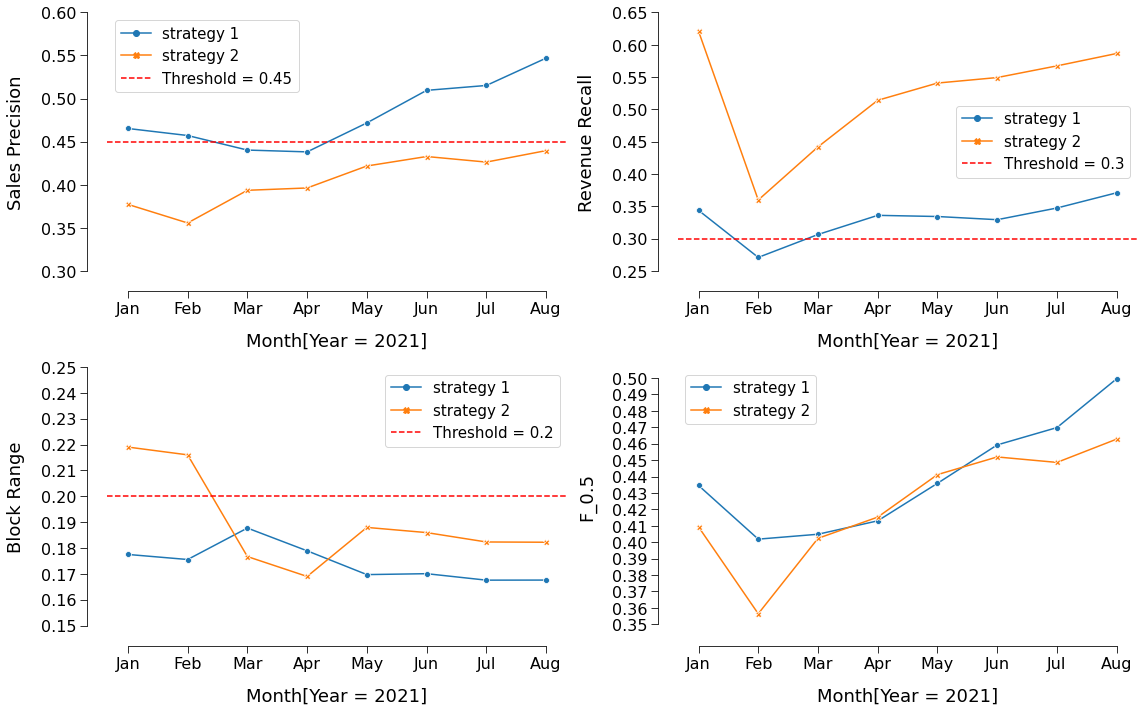

In [2041]:
fig, axes = plt.subplots(2,2,figsize=(16,10))

## 付费转化
sns.lineplot(data=dat_fra, x="Month", y="Precision",hue="Strategy",style = "Strategy",dashes=False,markers = True,ax =axes[0,0])

axes[0,0].tick_params(axis= "both",direction = 'out',which='major', length=6.8,width=0.8,labelsize =16)

axes[0,0].set_xlabel("Month[Year = 2021]",size = 18,labelpad=16)
axes[0,0].set_ylabel("Sales Precision",size = 18,labelpad=16)

axes[0,0].spines['left'].set_bounds(0.3,0.6)
axes[0,0].spines['bottom'].set_bounds(0,7)

axes[0,0].axhline(y=0.45, color='r', linestyle='--',label = "Threshold = 0.45")

# plt.tight_layout()
axes[0,0].set_yticks([0.05*i for i in range(6,13)])
axes[0,0].legend(loc="best",fontsize = 15)
adjust_spines(axes[0,0], ['left', 'bottom'])


## 收入召回
sns.lineplot(data=dat_fra, x="Month", y="Recall",hue="Strategy",style = "Strategy",dashes=False,markers=True,ax =axes[0,1])


axes[0,1].tick_params(axis= "both",direction = 'out',which='major',length=6.8,width=0.8,labelsize =16)

axes[0,1].set_xlabel("Month[Year = 2021]",size = 18,labelpad=16)
axes[0,1].set_ylabel("Revenue Recall",size = 18,labelpad=16)


axes[0,1].spines['left'].set_bounds(0.25,0.65)
axes[0,1].spines['bottom'].set_bounds(0,7)
axes[0,1].axhline(y=0.3, color='r', linestyle='--',label = "Threshold = 0.3")

# plt.tight_layout()
axes[0,1].set_yticks([0.05*i for i in range(5,14)])
axes[0,1].legend(loc="best",fontsize = 15)

adjust_spines(axes[0,1],['left', 'bottom'])


## 阻断范围
sns.lineplot(data=dat_fra, x="Month", y="Block Range",hue = "Strategy",style = "Strategy",dashes=False,markers = True,ax =axes[1,0])


axes[1,0].tick_params(axis= "both",direction = 'out',which='major',length=6.8,width=0.8,labelsize =16)#

axes[1,0].set_xlabel("Month[Year = 2021]",size = 18,labelpad=16)
axes[1,0].set_ylabel("Block Range",size = 18,labelpad=16)


axes[1,0].spines['left'].set_bounds(0.15,0.25)
axes[1,0].spines['bottom'].set_bounds(0,7)
axes[1,0].axhline(y=0.2, color='r', linestyle='--',label = "Threshold = 0.2")

# plt.tight_layout()
axes[1,0].set_yticks([0.01*i for i in range(15,26)])
axes[1,0].legend(loc="best",fontsize = 15)

adjust_spines(axes[1,0], ['left', 'bottom'])

## F_0.5
sns.lineplot(data=dat_fra, x="Month", y="F_score",hue="Strategy",style = "Strategy",dashes=False,markers = True,ax =axes[1,1])


axes[1,1].tick_params(axis= "both",direction = 'out',which='major',length=6.8,width=0.8,labelsize =16)#

axes[1,1].set_xlabel("Month[Year = 2021]",size = 18,labelpad=16)
axes[1,1].set_ylabel("F_0.5",size = 18,labelpad=16)


axes[1,1].spines['left'].set_bounds(0.35,0.5)
axes[1,1].spines['bottom'].set_bounds(0,7)



axes[1,1].set_yticks([0.01*i for i in range(35,51)])
axes[1,1].legend(loc="best",fontsize = 15)

adjust_spines(axes[1,1], ['left', 'bottom'])

plt.tight_layout()


# plt.savefig("/code/fxl/head_fire/test_variance/var.png",dpi = 400)

In [2002]:
dat_fra

,Strategy,Month,Precision,Recall,Block Range,F_score
0,strategy 1,Jan,0.465278,0.343760,0.177488,0.434555
1,strategy 1,Feb,0.457122,0.270876,0.175529,0.401861
2,strategy 1,Mar,0.440232,0.306333,0.187698,0.404841
3,strategy 1,Apr,0.438128,0.335968,0.178891,0.413011
4,strategy 1,May,0.471751,0.334160,0.169690,0.435858
5,strategy 1,Jun,0.509530,0.329235,0.170046,0.459233
6,strategy 1,Jul,0.515208,0.347313,0.167543,0.469788
7,strategy 1,Aug,0.546930,0.370909,0.167574,0.499519
8,strategy 2,Jan,0.377193,0.621074,0.219028,0.409341
9,strategy 2,Feb,0.355629,0.359699,0.216014,0.356436


In [2033]:
dat_fra.iloc[:,[0,2,3,4,5]].groupby(["Strategy"]).std()

,Precision,Recall,Block Range,F_score
Strategy,,,,
strategy 1,0.039155,0.029932,0.006995,0.034363
strategy 2,0.029559,0.084451,0.018045,0.034850


# First stage

## Training

### h_boss_ratio_begin_bin

In [1842]:
mar_full["h_boss_ratio_begin_bin"] = 0
mar_full.loc[(mar_full.is_new_com == 0)&(mar_full.h_boss_ratio_begin >0.4),"h_boss_ratio_begin_bin"] = 1

metric(mar_full,"h_boss_ratio_begin_bin")

Precision = 0.520,Recall = 0.084,Block Range = 0.138,F_score = 0.255


### Play around with the other variables

In [1805]:
jan_full["other_bin"] = 0
jan_full.loc[(aug_full.is_new_com == 0)&(aug_full.del_exp_cnt_365 >=1),"other_bin"] = 1

metric(jan_full,"other_bin")

Precision = 0.306,Recall = 0.245,Block Range = 0.242,F_score = 0.291


### Synthetic strategy

In [1806]:
jan_full["h_boss_ratio_begin_bin"] = 0
jan_full.loc[(jan_full.h_boss_ratio_begin >0.4),"h_boss_ratio_begin_bin"] = 1

#### strategy 1

In [1832]:
mar_full["combine_bin_te_1"] = 0
mar_full.loc[(mar_full.is_new_com == 0)&(((mar_full.h_boss_ratio_begin_bin == 1))|((mar_full.actj_365 <4)&(mar_full.exposure_pv_14 <8)))&(mar_full.exposure_pv_180>=1),"combine_bin_te_1"] = 1

metric(mar_full,"combine_bin_te_1")

Precision = 0.421,Recall = 0.288,Block Range = 0.186,F_score = 0.385


In [1835]:
metric(mar_full,"combine_bin_te_1")

Precision = 0.421,Recall = 0.288,Block Range = 0.186,F_score = 0.385


#### strategy 2

In [1106]:
aug_full["combine_bin_te_2"] = 0
aug_full.loc[(aug_full.is_new_com == 0)&(((aug_full.h_boss_ratio_begin_bin == 1))|((aug_full.actj_365 <4)&(aug_full.exposure_pv_14 <8)))&((aug_full.del_exp_cnt_365>=1)|(aug_full.exposure_pv_90>=1)),"combine_bin_te_2"] = 1

#aug_full.loc[(((aug_full.h_boss_ratio_begin_bin == 1))|((aug_full.actj_365 <4)&(aug_full.exposure_pv_14 <8)))&(aug_full.exposure_pv_180>=1),"combine_bin_te"] = 1
#aug_full.loc[((aug_full.h_boss_ratio_begin_bin == 1))|((aug_full.actj_365 <4)&(aug_full.exposure_pv_14 <8))&((aug_full.exposure_pv_180>=1)),"combine_bin_te"] = 1

metric(aug_full,"combine_bin_te_2")

Precision = 0.496,Recall = 0.306,Block Range = 0.135,F_score = 0.441


#### strategy 3

In [1107]:
aug_full["combine_bin_te_3"] = 0

con1 = ((aug_full.h_boss_ratio_begin >0.4)&(aug_full.brand_scale == 0))|(aug_full.actj_365 <2)&(aug_full.exposure_pv_14 < 8)&(aug_full.exposure_pv_180>=1)
con2 = ((aug_full.h_boss_ratio_begin >0.2)&(aug_full.brand_scale == "0-20人"))|(aug_full.actj_365 <6)&(aug_full.exposure_pv_14 <20)&(aug_full.exposure_pv_180>=6)
con3 = ((aug_full.h_boss_ratio_begin >0)&(aug_full.brand_scale == "20-99人"))|(aug_full.actj_365 <2)&(aug_full.exposure_pv_14 < 8)&(aug_full.exposure_pv_180>=4)
con4 = ((aug_full.h_boss_ratio_begin >0)&(aug_full.brand_scale == "100-499人"))|(aug_full.actj_365 <2)&(aug_full.exposure_pv_14 < 8)&(aug_full.exposure_pv_180>=1)
con5 = ((aug_full.m_boss_ratio_begin>0.4)&(aug_full.brand_scale == "500-999人"))|(aug_full.actj_365 <2)&(aug_full.exposure_pv_14 < 8)&(aug_full.exposure_pv_180>=1)

aug_full.loc[(aug_full.is_new_com == 0)&(con1|con2|con3|con4|con5),"combine_bin_te_3"] = 1

metric(aug_full,"combine_bin_te_3")

Precision = 0.473,Recall = 0.362,Block Range = 0.179,F_score = 0.446


#### strategy 4

In [1108]:
aug_full["combine_bin_te_4"] = 0

con1 = ((aug_full.h_boss_ratio_begin >0.4)&(aug_full.brand_scale == 0))|(aug_full.actj_365 <2)&(aug_full.exposure_pv_14 < 8)&(aug_full.exposure_pv_180>=1)
con2 = ((aug_full.h_boss_ratio_begin >0.2)&(aug_full.brand_scale == "0-20人"))|(aug_full.actj_365 <6)&(aug_full.exposure_pv_14 <20)&(aug_full.exposure_pv_180>=6)
con3 = ((aug_full.h_boss_ratio_begin >0)&(aug_full.brand_scale == "20-99人"))|(aug_full.actj_365 <2)&(aug_full.exposure_pv_14 < 8)&(aug_full.exposure_pv_180>=4)
con4 = ((aug_full.h_boss_ratio_begin >0.3)&(aug_full.brand_scale == "100-499人"))|(aug_full.actj_365 <2)&(aug_full.exposure_pv_14 < 8)&(aug_full.exposure_pv_180>=1)
con5 = ((aug_full.m_boss_ratio_begin>0.4)&(aug_full.brand_scale == "500-999人"))|(aug_full.actj_365 <2)&(aug_full.exposure_pv_14 < 8)&(aug_full.exposure_pv_180>=1)
con6 = ((aug_full.h_boss_ratio_begin>0)&(aug_full.brand_scale == "1000-9999人"))|(aug_full.actj_365 <2)&(aug_full.exposure_pv_14 < 8)&(aug_full.exposure_pv_180>=1)

aug_full.loc[(aug_full.is_new_com == 0)&(con1|con2|con3|con4|con5|con6),"combine_bin_te_4"] = 1

metric(aug_full,"combine_bin_te_4")

Precision = 0.475,Recall = 0.364,Block Range = 0.187,F_score = 0.448


#### strategy 5

In [1676]:
con = ((aug_full.h_boss_ratio_begin >0.3)|(aug_full.olj_1== 0))&((aug_full.del_exp_cnt_365>=0)&(aug_full.exposure_pv_180>=0))

aug_full["com_bin_final"] = 0
aug_full.loc[(con)&(aug_full.is_new_com == 0),"com_bin_final"] = 1

metric(aug_full,"com_bin_final")

Precision = 0.428,Recall = 0.479,Block Range = 0.131,F_score = 0.437


#### strategy 6

In [1761]:
con = (((aug_full.h_boss_ratio_begin >0.3)|(aug_full.h_boss_ratio_end >0.3))|((aug_full.olj_1== 0)&((aug_full.del_exp_cnt_365>0)&(aug_full.exposure_pv_180>0))))

aug_full["com_bin_final"] = 0
aug_full.loc[(con)&(aug_full.is_new_com == 0),"com_bin_final"] = 1

metric(aug_full,"com_bin_final")

Precision = 0.512,Recall = 0.413,Block Range = 0.168,F_score = 0.489


#### strategy 7

In [1758]:
con = (((aug_full.h_boss_ratio_begin >0.3)|(aug_full.h_boss_ratio_end >0.3))|((aug_full.olj_1==0)&((aug_full.del_exp_cnt_365>=27)|(aug_full.exposure_pv_180>=698)|(aug_full.accepts_p_365>=10))))

aug_full["com_bin_final"] = 0
aug_full.loc[(con)&(aug_full.is_new_com == 0),"com_bin_final"] = 1

metric(aug_full,"com_bin_final")

Precision = 0.547,Recall = 0.371,Block Range = 0.168,F_score = 0.500


In [1767]:
aug_full.brand_scale.value_counts()

0             90041
20-99人        36936
100-499人      26007
0-20人         15970
1000-9999人    13535
10000人以上      10937
500-999人       7696
Name: brand_scale, dtype: int64

#### strategy 8

In [1813]:
con = ((((jan_full.h_boss_ratio_begin >0.3)|(jan_full.h_boss_ratio_end >0.3))))|((jan_full.olj_1==0)&((jan_full.del_exp_cnt_365 >= 27)|(jan_full.exposure_pv_180>698)|(jan_full.accepts_p_365>=10)))

jan_full["com_bin_final"] = 0
jan_full.loc[(con)&(jan_full.is_new_com == 0),"com_bin_final"] = 1

metric(jan_full,"com_bin_final")

Precision = 0.462,Recall = 0.340,Block Range = 0.177,F_score = 0.431


In [1838]:
con = ((((feb_full.h_boss_ratio_begin >0.3)|(feb_full.h_boss_ratio_end >0.3))))|((feb_full.olj_1==0)&((feb_full.del_exp_cnt_365 >= 27)|(feb_full.exposure_pv_180>698)|(feb_full.accepts_p_365>=10)))

feb_full["com_bin_final"] = 0
feb_full.loc[(con)&(feb_full.is_new_com == 0),"com_bin_final"] = 1

metric(feb_full,"com_bin_final")

Precision = 0.457,Recall = 0.271,Block Range = 0.176,F_score = 0.402


In [1839]:
con = ((((mar_full.h_boss_ratio_begin >0.3)|(mar_full.h_boss_ratio_end >0.3))))|((mar_full.olj_1==0)&((mar_full.del_exp_cnt_365 >= 27)|(mar_full.exposure_pv_180>698)|(mar_full.accepts_p_365>=10)))

mar_full["com_bin_final"] = 0
mar_full.loc[(con)&(mar_full.is_new_com == 0),"com_bin_final"] = 1

metric(mar_full,"com_bin_final")

Precision = 0.462,Recall = 0.340,Block Range = 0.177,F_score = 0.431


In [1828]:
con = ((((apr_full.h_boss_ratio_begin >0.3)|(apr_full.h_boss_ratio_end >0.3))))|((apr_full.olj_1==0)&((apr_full.del_exp_cnt_365 >= 27)|(apr_full.exposure_pv_180>698)|(apr_full.accepts_p_365>=10)))

apr_full["com_bin_final"] = 0
apr_full.loc[(con)&(apr_full.is_new_com == 0),"com_bin_final"] = 1

metric(apr_full,"com_bin_final")

Precision = 0.438,Recall = 0.336,Block Range = 0.179,F_score = 0.413


## Just play around

In [1736]:
#con1 = ((aug_full.h_boss_ratio_begin >0.3)|((aug_full.olj_1== 0)&((aug_full.view_p_365>=1))))&((aug_full.del_exp_cnt_365>=3)|(aug_full.exposure_pv_180>=640))
con1 = (aug_full.olj_1== 0)
#con1 = ((aug_full.h_boss_ratio_begin >0.3)|(aug_full.h_boss_ratio_end >0.3))

#con2 = (((aug_full.olj_1== 0)&((aug_full.actj_365>=1)|(aug_full.del_exp_cnt_365>=3)|(aug_full.duplicate_af_pv_365>=643))))

In [1737]:
aug_full["com_bin_final"] = 0

aug_full.loc[(con1)&(aug_full.is_new_com == 0),"com_bin_final"] = 1

In [1738]:
metric(aug_full,"com_bin_final")

Precision = 0.408,Recall = 0.399,Block Range = 0.000,F_score = 0.406


In [1747]:
for i in range(100):
    aug_full["com_bin_tr"] = 0
    con1 = (((aug_full.m_boss_ratio_begin >0.3)|(aug_full.h_boss_ratio_end >0.3))|((aug_full.olj_1==0)&((aug_full.del_exp_cnt_365>=27)|(aug_full.exposure_pv_180>=698))))
    print(i)
    aug_full.loc[con1&(aug_full.is_new_com == 0),"com_bin_tr"] = 1
    metric(aug_full,"com_bin_tr")

0
Precision = 0.549,Recall = 0.470,Block Range = 0.469,F_score = 0.531
1
Precision = 0.549,Recall = 0.470,Block Range = 0.469,F_score = 0.531
2
Precision = 0.549,Recall = 0.470,Block Range = 0.469,F_score = 0.531
3
Precision = 0.549,Recall = 0.470,Block Range = 0.469,F_score = 0.531
4
Precision = 0.549,Recall = 0.470,Block Range = 0.469,F_score = 0.531
5
Precision = 0.549,Recall = 0.470,Block Range = 0.469,F_score = 0.531
6
Precision = 0.549,Recall = 0.470,Block Range = 0.469,F_score = 0.531
7
Precision = 0.549,Recall = 0.470,Block Range = 0.469,F_score = 0.531
8
Precision = 0.549,Recall = 0.470,Block Range = 0.469,F_score = 0.531
9
Precision = 0.549,Recall = 0.470,Block Range = 0.469,F_score = 0.531
10
Precision = 0.549,Recall = 0.470,Block Range = 0.469,F_score = 0.531
11
Precision = 0.549,Recall = 0.470,Block Range = 0.469,F_score = 0.531
12
Precision = 0.549,Recall = 0.470,Block Range = 0.469,F_score = 0.531
13
Precision = 0.549,Recall = 0.470,Block Range = 0.469,F_score = 0.531
14

# Strategy Presentation

## Final strategy of white head block

**所有策略用到条件**：
- con1: h_boss_ratio_begin >0.3
- con2: h_boss_ratio_end >0.3
- con3: olj_1== 0
- con4: del_exp_cnt_365>=27
- con5: exposure_pv_180>=698
- con6: accepts_p_365>=10

**最终合成策略**：
$$
con1 \cup con2 \cup (con3 \cap (con4 \cup con5 \cup con6))
$$